In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import numdifftools as ndt
from scipy.stats import f

In [2]:
# load flow rate data
flow_data = pd.read_csv('flow_data.csv')
lc_data = pd.read_csv('lc_data.csv')
teaf      = 0.00721
teaden    = 0.728
cBf = teaf

In [3]:
tQf = np.insert(flow_data['t'].values, 0, 0)
Qf = np.insert(flow_data["Qf"].values / teaden, 0, 0)

In [4]:
tlc = lc_data['t'].values
lc = lc_data['lc_meas'].values

In [5]:
Qf_if = interp1d(tQf, Qf, 'previous', bounds_error = False)

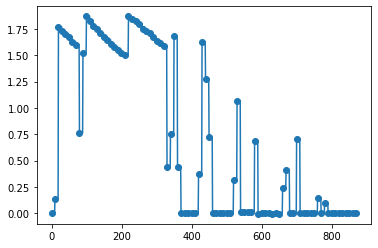

In [6]:
t_i = np.arange(0.0, 850.0)
Qf_i = [Qf_if(t) for t in t_i]

fig, ax = plt.subplots()
ax.scatter(tQf, Qf)
ax.plot(t_i, Qf_i)

In [7]:
def rates_red(t, y, p):
    
    vR = y[0]
    eps2 = y[1]
    
    Qf_if = p[0]
    nA0 = p[1]
    k = p[2]
    
    cBf = 0.00721
    vR0 = 2370.0
    
    nBadded = max((vR - vR0) * cBf,1.0e-6)
    
    dvR = Qf_if
    deps2 = Qf_if * cBf / (1.0 + k * (nA0 - nBadded + eps2)/(nBadded - 2.0 * eps2))
    
    return [dvR, deps2]

In [8]:
def get_lcpred(sol):
    
    cBf = 0.00721
    vR0 = 2370.0
    
    vR = sol[0,:]
    eps2 = sol[1:,]
    
    nBadded = (vR - vR0) * cBf
    nD = eps2
    nC = nBadded - 2.0 * nD
    
    lc_pred =  1 / (1 + 2.0*nD/np.maximum(nC, 1e-6))
    
    return lc_pred

In [80]:
def get_lc_sse(sol_l_t, sol_l_y, lc_data):
    tlc = lc_data['t'].values
    lc = lc_data['lc_meas'].values
    sol_vR_int = interp1d(sol_l_t, sol_l_y[0,:], 'linear', bounds_error = False)
    sol_eps2_int = interp1d(sol_l_t, sol_l_y[1,:], 'linear', bounds_error = False)
    sol_vR = np.array([sol_vR_int(t) for t in tlc])
    sol_eps2 = np.array([sol_eps2_int(t) for t in tlc])
    sol = np.vstack((sol_vR, sol_eps2))
    lc_pred = get_lcpred(sol)[0,:]
    lc_ratio = lc_pred/lc
    sse = np.sum((lc_ratio - 1.0)**2)
    return sse

In [81]:
tmp = get_lc_sse(sol_l_t, sol_l_y, lc_data)
tmp

0.1167538499043078

In [9]:
y0 = [2370.0, 0.0]

for (i, t) in enumerate(tQf[:-1]):
    print(i)
    tspan = [0.0, tQf[i+1] - tQf[i]]
    p = [Qf[i], 2.35, 2.0]
    sol = solve_ivp(rates_red, tspan, y0, method = "BDF", args = (p,))
    sol.t = sol.t + tQf[i]
    y0 = sol.y[:,-1]
    if i == 0:
        sol_l_t = np.copy(sol.t)
        sol_l_y = np.copy(sol.y)
    else:
        sol_l_t = np.concatenate((sol_l_t, sol.t))
        sol_l_y = np.concatenate((sol_l_y, sol.y), axis = 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


In [47]:
def simprob(p, tQf, Qf):

    y0 = [2370.0, 0.0]

    for (i, t) in enumerate(tQf[:-1]):
        #print(i)
        tspan = [0.0, tQf[i+1] - tQf[i]]
        p_ext = [Qf[i], p[0], p[1]]
        sol = solve_ivp(rates_red, tspan, y0, method = "BDF", args = (p_ext,))
        sol.t = sol.t + tQf[i]
        y0 = sol.y[:,-1]
        if i == 0:
            sol_l_t = np.copy(sol.t)
            sol_l_y = np.copy(sol.y)
        else:
            sol_l_t = np.concatenate((sol_l_t, sol.t))
            sol_l_y = np.concatenate((sol_l_y, sol.y), axis = 1)
            
    return sol_l_t, sol_l_y

In [49]:
sol_l_t, sol_l_y = simprob([2.35, 2.0], tQf, Qf)

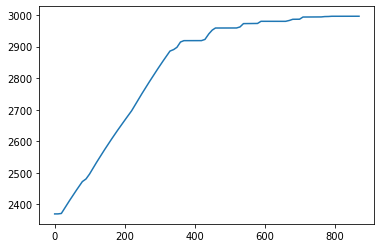

In [51]:
fig, ax = plt.subplots()
ax.plot(sol_l_t, sol_l_y[0,:])

In [52]:
lc_sim = get_lcpred(sol_l_y)
lc_sim[0,:].shape

(540,)

(0.0, 0.2)

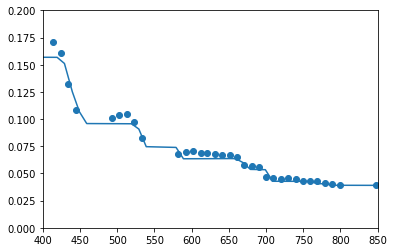

In [55]:
fig, ax = plt.subplots()
ax.scatter(tlc, lc)
ax.plot(sol_l_t, lc_sim[0,:])
ax.set_xlim([400.0, 850.0])
ax.set_ylim([0.0, 0.2])

In [82]:
def calc_SSE(pest, data):
    sol_l_t, sol_l_y = simprob(pest, data['tQf'], data['Qf'])
    SSE = get_lc_sse(sol_l_t, sol_l_y, data['lc_data'])
    return SSE

In [83]:
pest_data = {'Qf_if': Qf_if, 'lc_data': lc_data, 'tQf': tQf, 'Qf': Qf}

In [84]:
calc_SSE([2.35, 2.0], pest_data)

0.1167538499043078

In [102]:
pe_sol = minimize(calc_SSE, [2.35, 1.0], args = pest_data, method = "L-BFGS-B")

In [103]:
pe_sol

      fun: 0.09747117937683189
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.24098519e-05,  1.60982340e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 20
     njev: 22
   status: 0
  success: True
        x: array([2.35030986, 2.19681753])

In [85]:
calc_SSE_lam = lambda pest: calc_SSE(pest, pest_data)

In [86]:
tmp = ndt.Hessian(calc_SSE_lam)

In [87]:
H = tmp([2.35, 2.0])

In [88]:
H

array([[3.76160706e+03, 5.25091422e+01],
       [5.25091422e+01, 1.43718297e+00]])

In [89]:
np.linalg.inv(H) 

array([[ 5.42556857e-04, -1.98229424e-02],
       [-1.98229424e-02,  1.42005976e+00]])

In [90]:
mse = calc_SSE([2.35, 2.0], pest_data)/33
mse

0.003537995451645691

In [68]:
lc_data.shape

(35, 2)

In [91]:
cov_est = 2 * mse * np.linalg.inv(H)
cov_est

array([[ 3.83912738e-06, -1.40266960e-04],
       [-1.40266960e-04,  1.00483300e-02]])

In [98]:
nparam = 2
ndata = 35
alpha = 0.95
mult_factor = np * f.ppf(alpha, nparam, ndata - nparam)
mult_factor

6.5698353020765765

In [101]:
conf_delta = np.sqrt(np.diag(cov_est) * mult_factor)
conf_delta

array([0.00502219, 0.25693554])